In [85]:
import json
from typing import *

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import cumtrapz, simps
from scipy.signal import butter, filtfilt, iirnotch, spectrogram, welch

In [2]:
def data_prepare(
    filename: str,
    low_pass: int = 10,
    sfreq: int = 1000,
    high_band: int = 20,
    low_band: int = 450,
) -> Tuple[np.ndarray, np.ndarray, Dict]:
    # Read data and correction to 3.3v
    df = pd.read_csv(f"{filename}.csv")
    values = df.to_numpy()
    time = values[:, 0]
    data = values[:, 1:] * 3.3 / 65535

    with open(f"{filename}_points.json", "r") as f:
        points = json.load(f)

    # Remove basline mean
    baseline_idx = np.argwhere(time >= points["baseline"])[0][0]
    baseline = data[:baseline_idx, :]
    x0 = np.mean(baseline, axis=0)

    normalize = data - x0
    yf = np.argwhere(time >= 22)[0][0]

    time = time[baseline_idx:yf]
    data_removed_mean = normalize[baseline_idx:yf, :]

    # create bandpass filter for EMG
    high = high_band / (sfreq / 2)
    low = low_band / (sfreq / 2)
    b, a = butter(4, [high, low], btype="bandpass")
    data_filtered = np.vstack(
        [
            filtfilt(b, a, data_removed_mean[:, i])
            for i in range(data_removed_mean.shape[1])
        ]
    ).T

    # notch filter
    b_notch, a_notch = iirnotch(50.0, 30.0, sfreq)
    data_notched = np.vstack(
        [
            filtfilt(b_notch, a_notch, data_filtered[:, i])
            for i in range(data_filtered.shape[1])
        ]
    ).T

    # rectify emg signal
    data_rectified = abs(data_notched)

    # create lowpass filter and apply to rectified signal to get EMG envelope
    low_pass = low_pass / (sfreq / 2)
    b2, a2 = butter(4, low_pass, btype="lowpass")
    data_envelope = np.vstack(
        [filtfilt(b2, a2, data_rectified[:, i]) for i in range(data_rectified.shape[1])]
    ).T

    return time, data_envelope, points

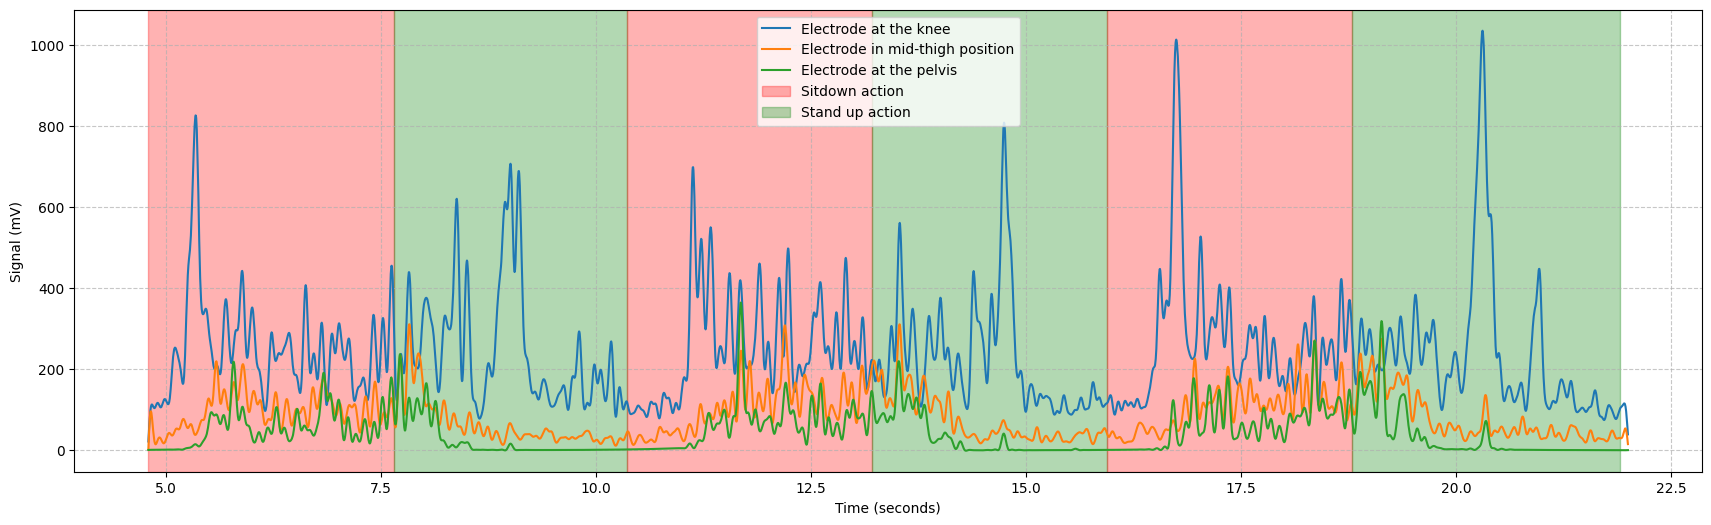

In [3]:
interval, emg, config = data_prepare(
    "../data/sitting/exp_1", low_pass=40, high_band=15, low_band=400
)

plt.figure(figsize=(21, 6))
plt.plot(interval, emg[:, 0] * 1000, label="Electrode at the knee")
plt.plot(interval, emg[:, 1] * 1000, label="Electrode in mid-thigh position")
plt.plot(interval, emg[:, 2] * 1000, label="Electrode at the pelvis")

plt.grid(True, linestyle="--", alpha=0.7)
plt.xlabel("Time (seconds)")
plt.ylabel("Signal (mV)")
c = ["r", "g"]
periods = []
for i in range(3):
    t0 = np.argwhere(interval >= config[f"close_{i}"])[0][0]
    tf = np.argwhere(interval >= config[f"open_{i}"])[0][0]
    periods.extend([t0, tf])
periods.append(np.argwhere(interval >= 21.9)[0][0])
for i in range(len(periods) - 1):
    if i in [0, 1]:
        plt.axvspan(
            interval[periods[i]],
            interval[periods[i + 1]],
            color=c[i % 2],
            alpha=0.3,
            label=f"{'Sitdown action' if i%2==0 else 'Stand up action'}",
        )
    else:
        plt.axvspan(
            interval[periods[i]], interval[periods[i + 1]], color=c[i % 2], alpha=0.3
        )
plt.legend()
plt.savefig("record_1_all.png")

# plt.figure(figsize=(21, 6))
# plt.plot(interval, 10 * np.log10(emg[:, 0]/emg[:, 1]), label="EMG 1 / EMG 2")

# plt.grid(True, linestyle="--", alpha=0.7)
# plt.xlabel("Time (seconds)")
# plt.ylabel("Signal (dB)")
# c = ["r", "g"]
# periods = []
# for i in range(3):
#     t0 = np.argwhere(interval >= config[f"close_{i}"])[0][0]
#     tf = np.argwhere(interval >= config[f"open_{i}"])[0][0]
#     periods.extend([t0, tf])
# periods.append(np.argwhere(interval >= 21.9)[0][0])
# for i in range(len(periods) - 1):
#     if i in [0, 1]:
#         plt.axvspan(interval[periods[i]], interval[periods[i + 1]], color=c[i%2], alpha=0.3, label=f"{'Up' if i%2==0 else 'Down'}")
#     else:
#         plt.axvspan(interval[periods[i]], interval[periods[i + 1]], color=c[i%2], alpha=0.3)
# plt.legend()
# plt.show()

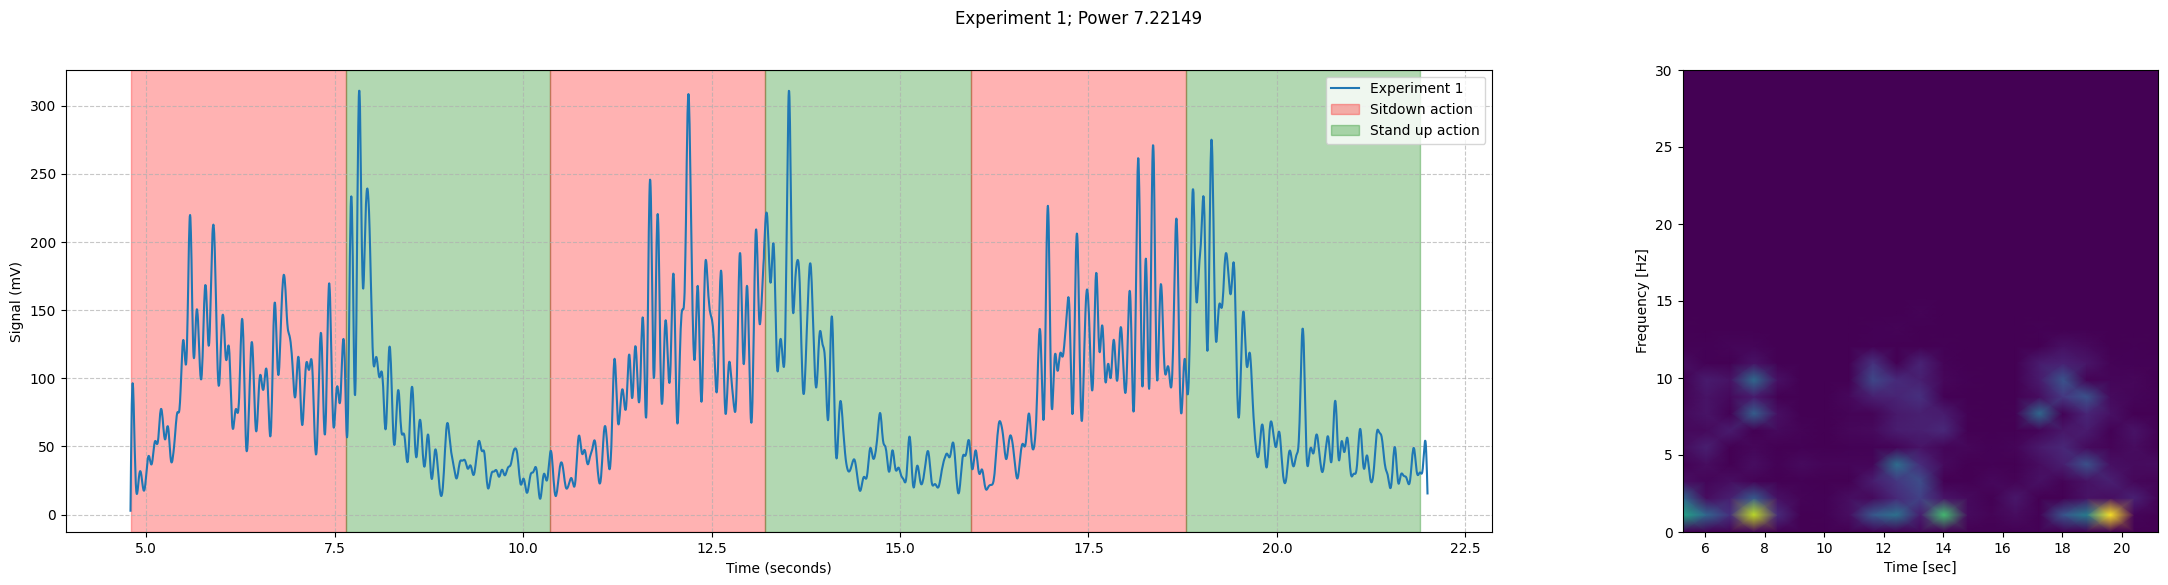

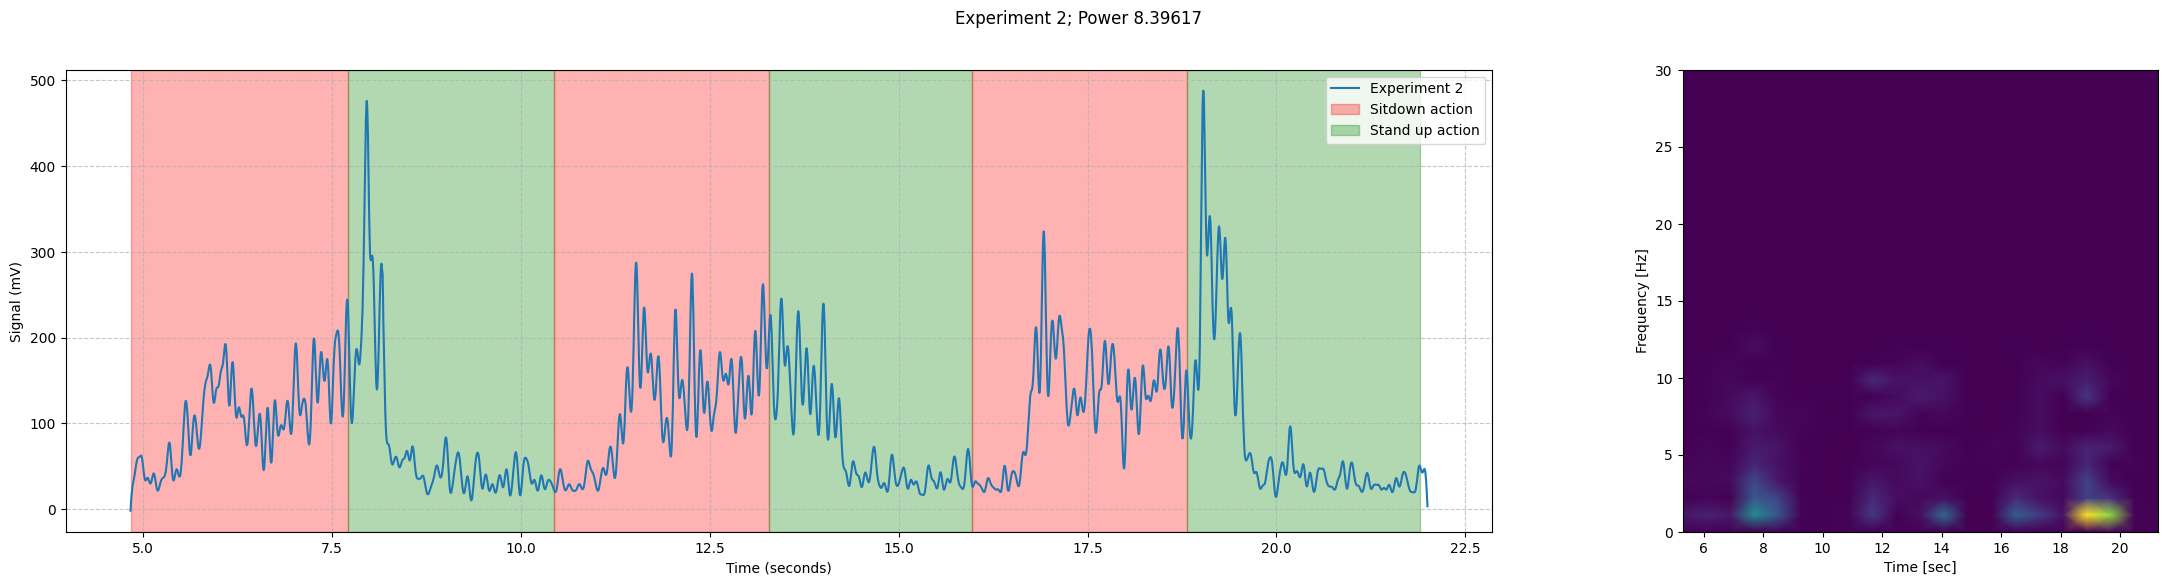

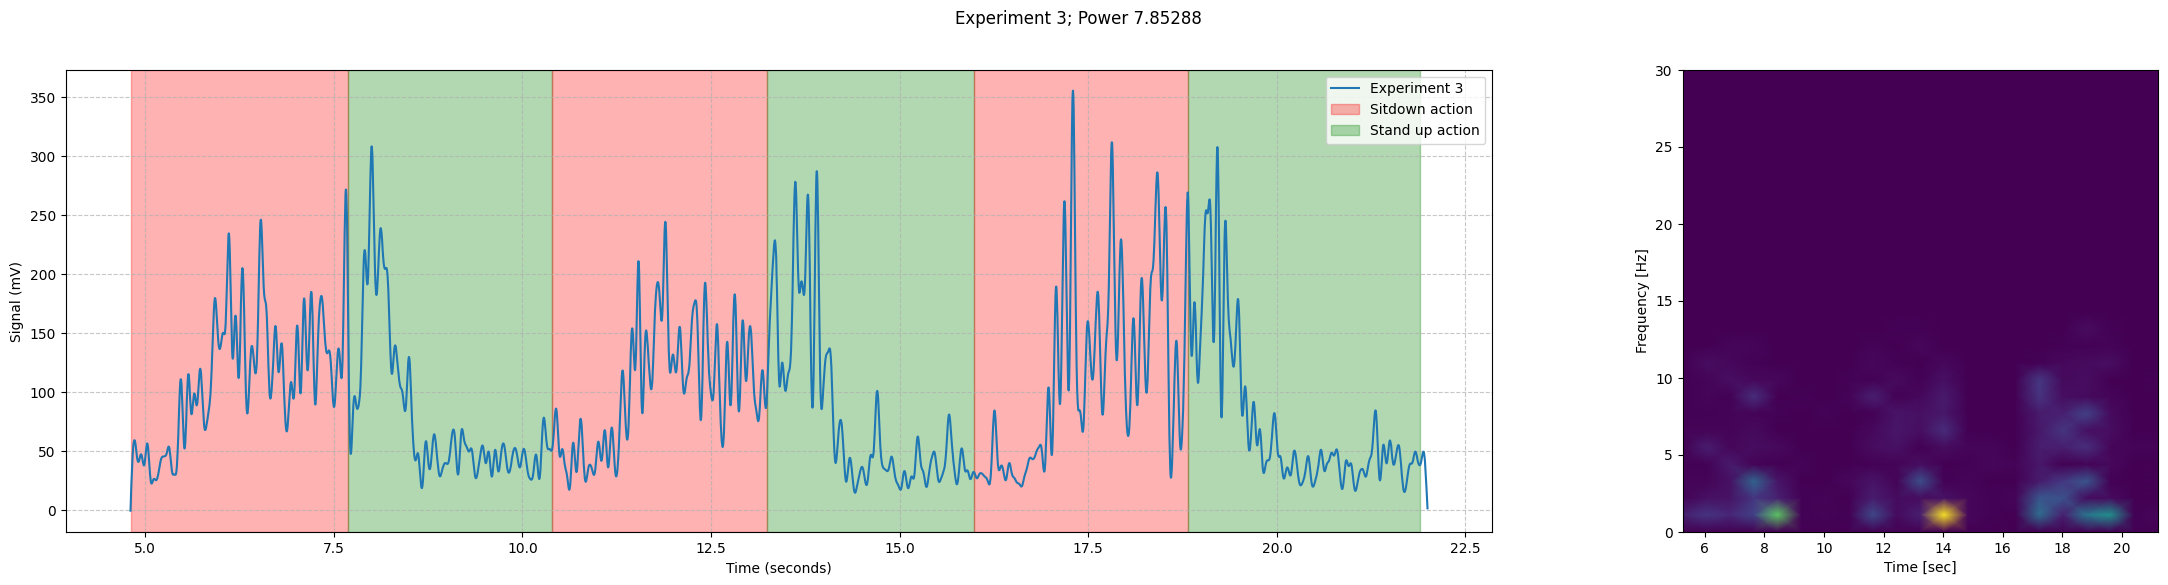

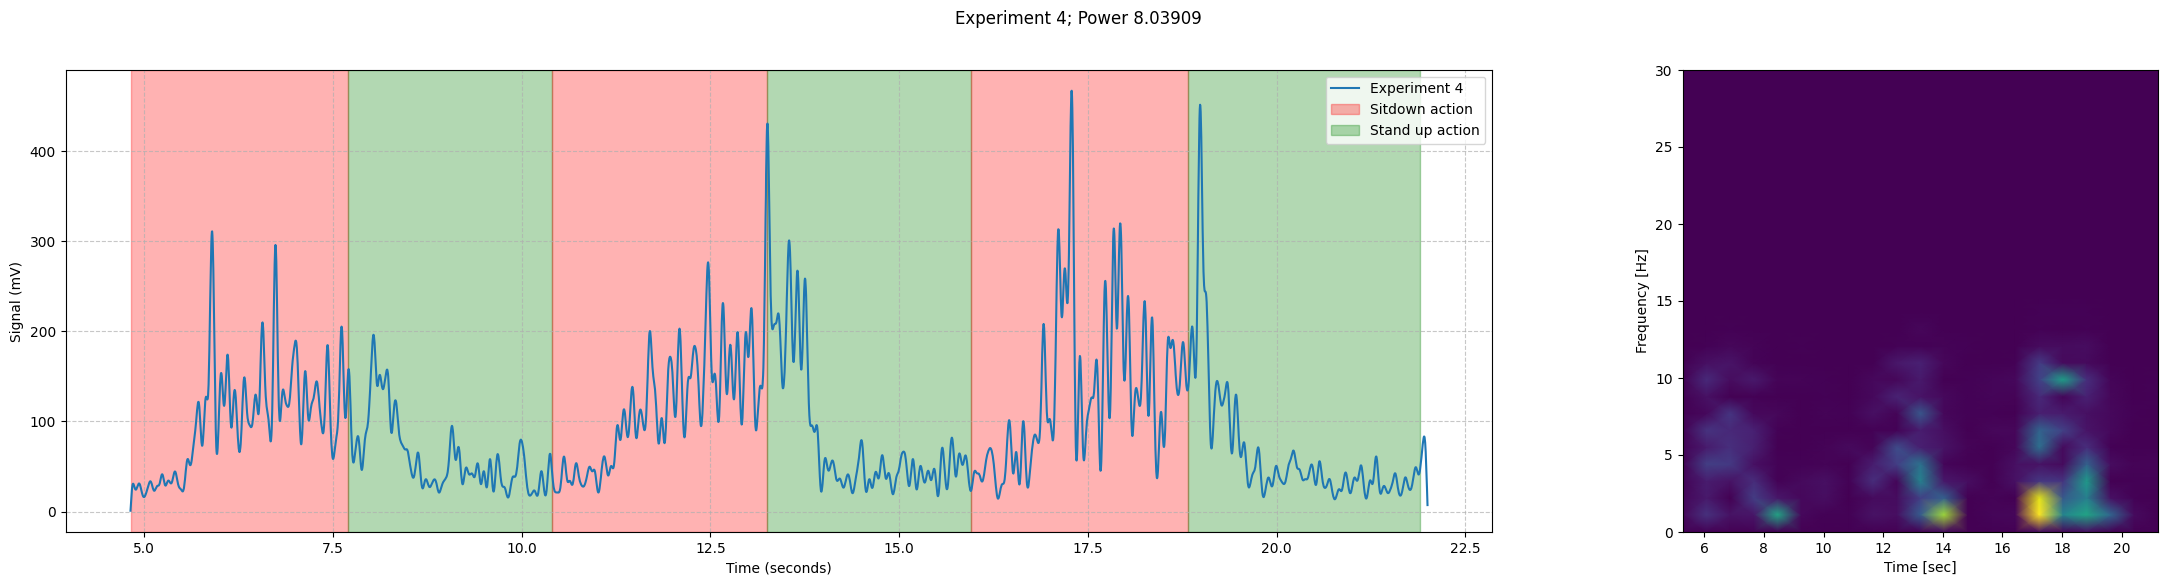

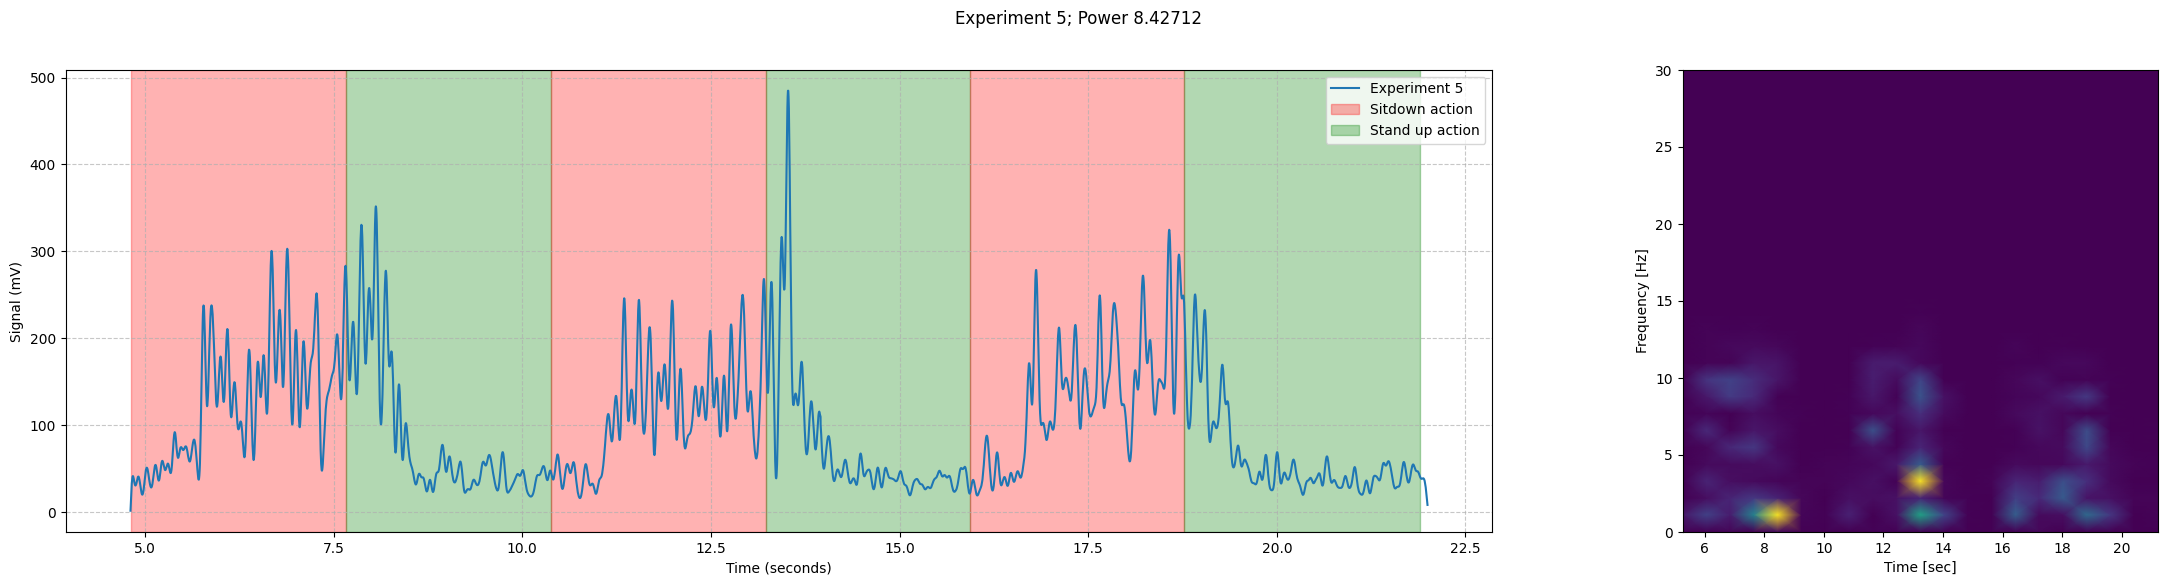

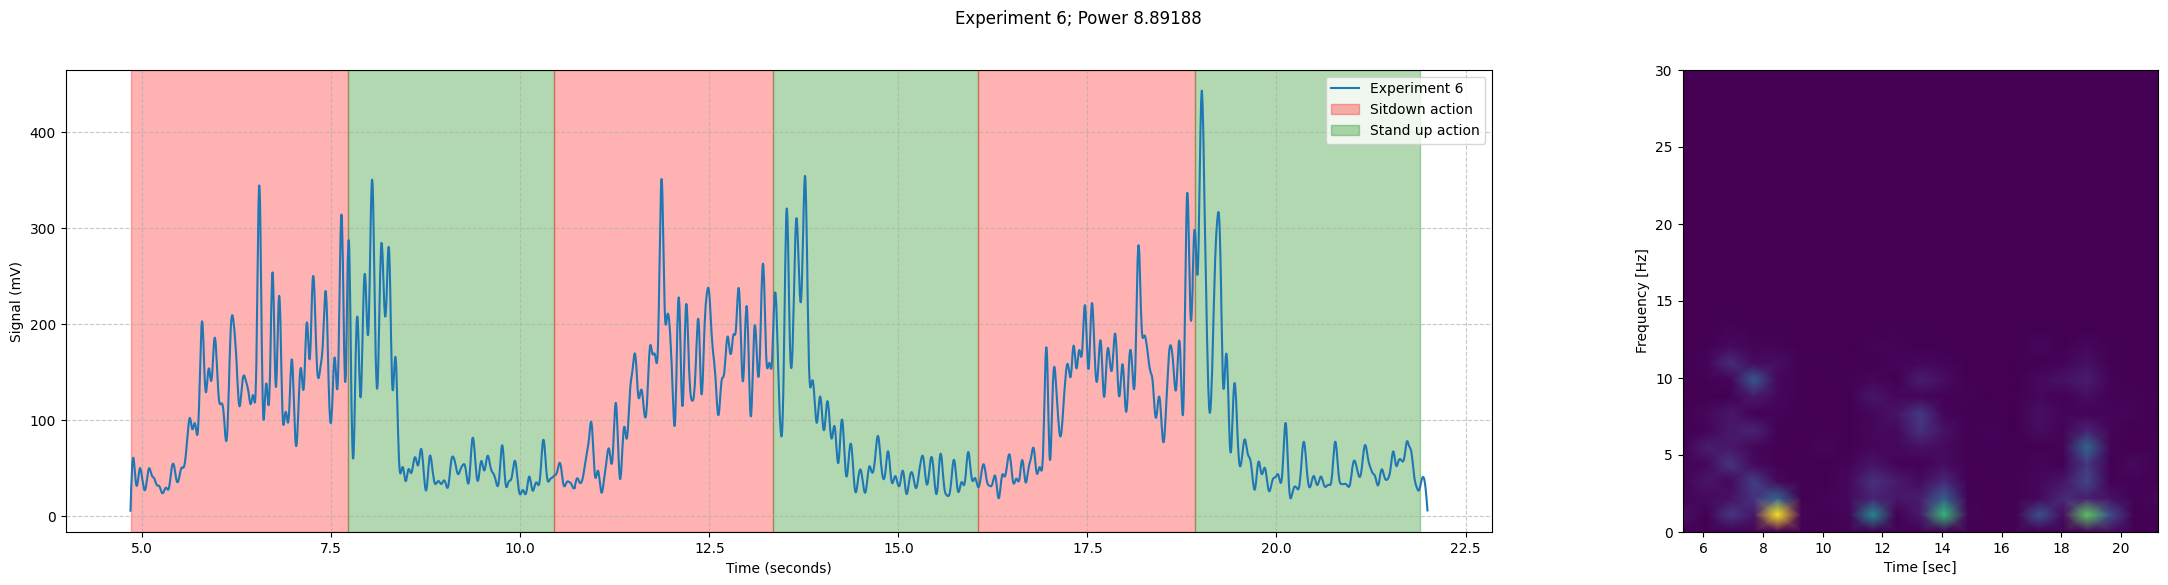

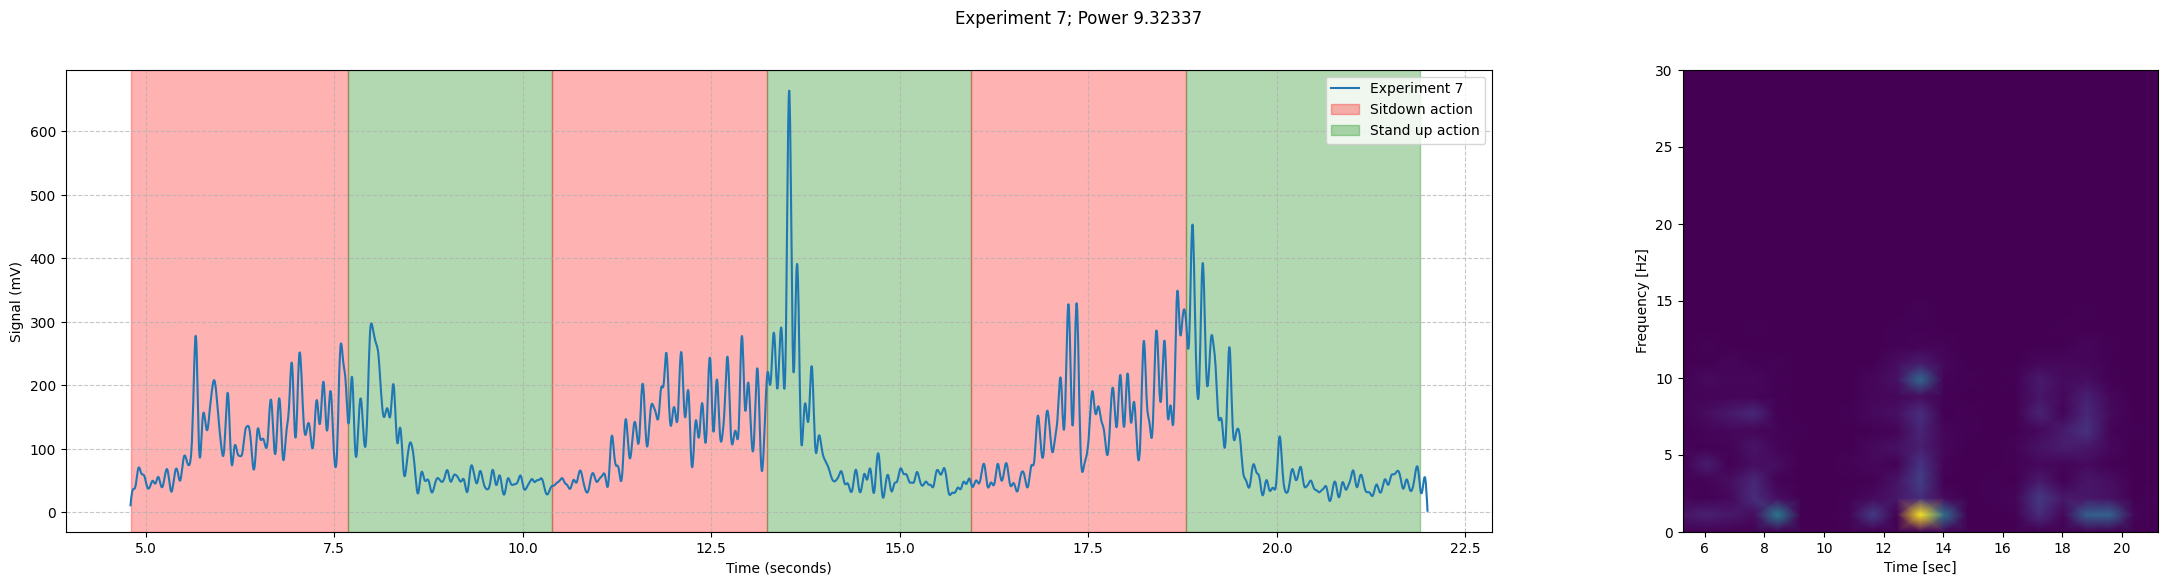

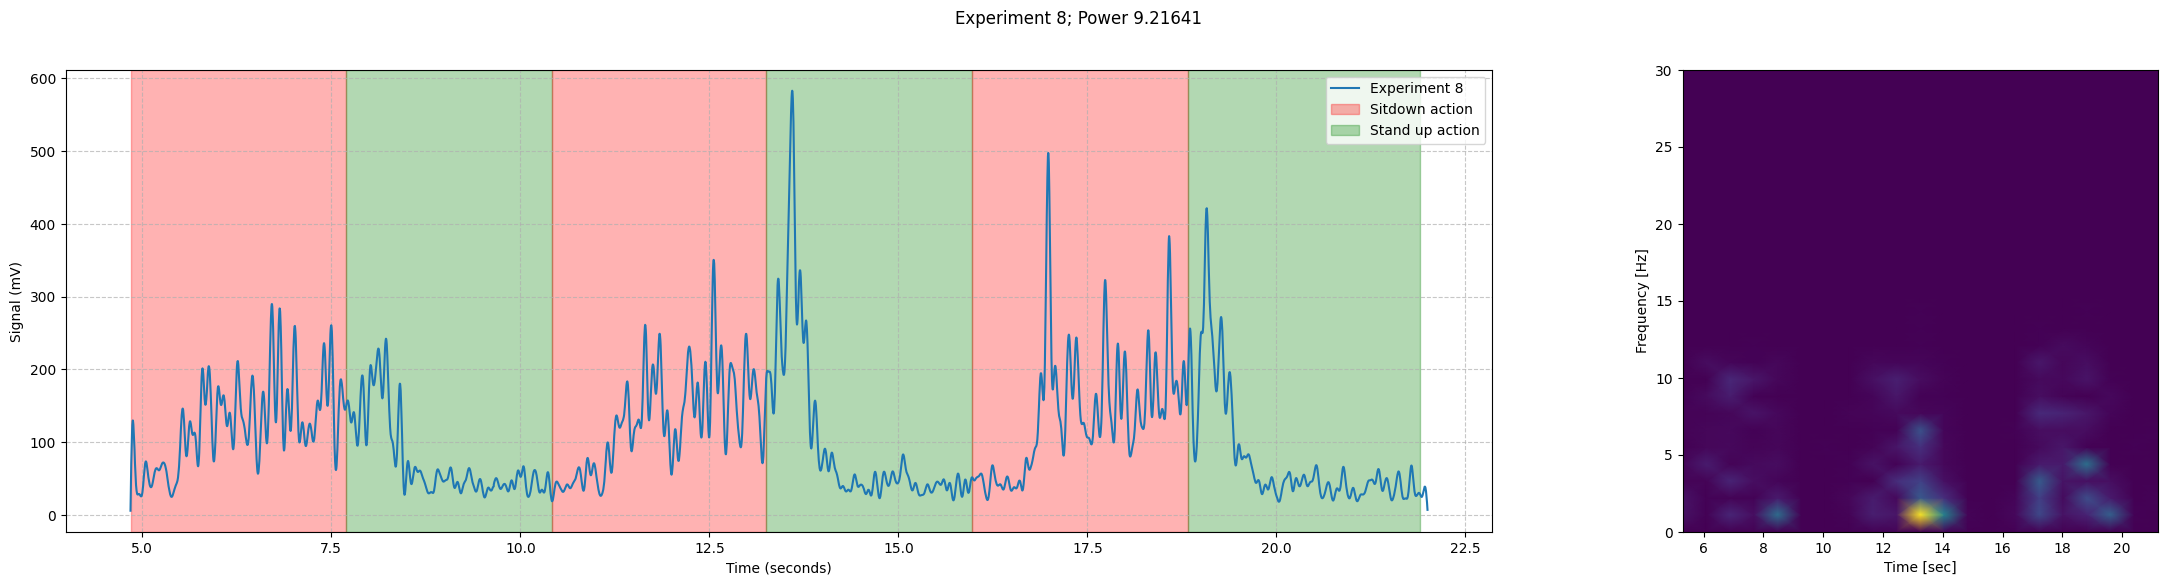

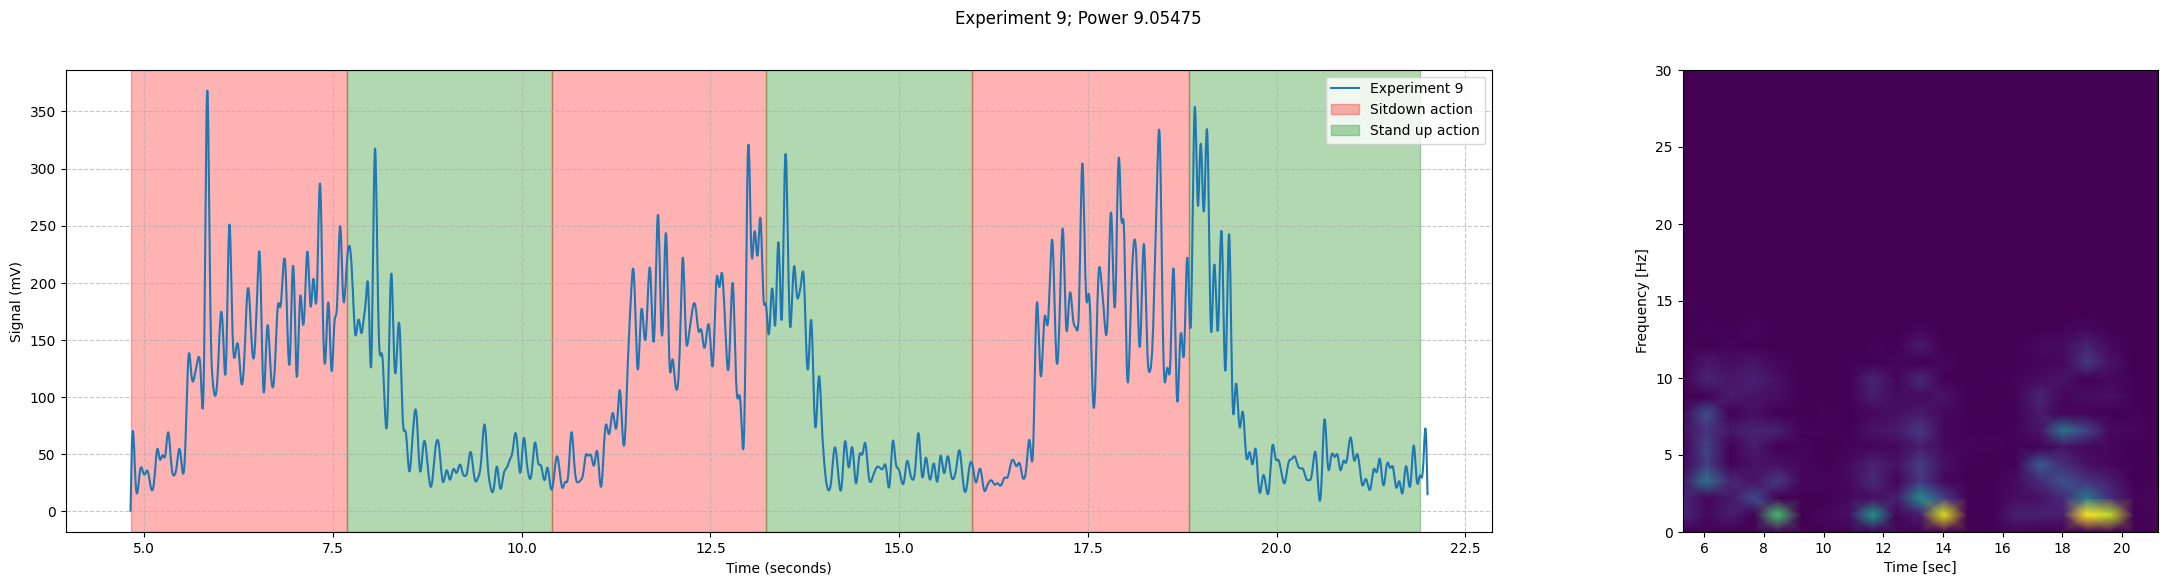

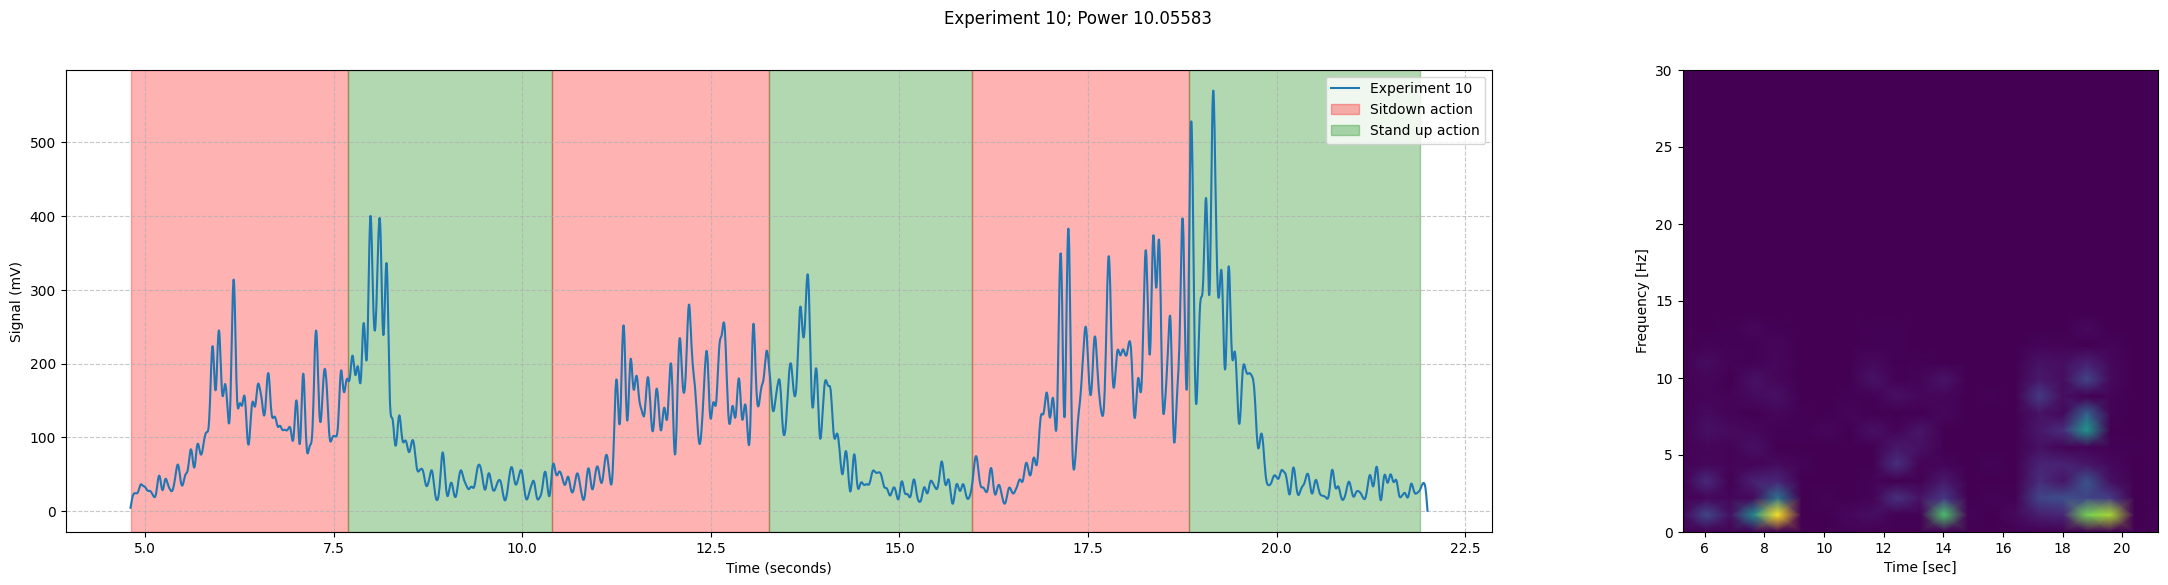

In [88]:
power = []
CHANNEL = 1
for exp in range(1, 11):
    interval, emg, config = data_prepare(
        f"../data/sitting/exp_{exp}", low_pass=40, high_band=15, low_band=400
    )

    f, P = welch(emg[:, CHANNEL], fs=1000, window="hann", noverlap=0, nfft=int(256.0))
    area_freq = cumtrapz(P, f, initial=0)
    total_power = area_freq[-1]

    total_power = np.sqrt(np.sum(np.power(emg[:, CHANNEL], 2)))
    power.append(
        [
            np.sqrt(np.sum(np.power(emg[:, 1], 2))),
            np.sqrt(np.mean(np.power(emg[:, 1], 2))),
            np.trapz(np.power(emg[:, 1], 2)),
            simps(np.power(emg[:, 1], 2)),
        ]
    )
    fig, axes = plt.subplots(
        1, 2, figsize=(27, 6), gridspec_kw={"width_ratios": [3, 1]}
    )
    fig.suptitle(f"Experiment {exp}; Power {total_power:.5f}")

    axes[0].plot(interval, emg[:, CHANNEL] * 1000, label=f"Experiment {exp}")

    axes[0].grid(True, linestyle="--", alpha=0.7)
    axes[0].set_xlabel("Time (seconds)")
    axes[0].set_ylabel("Signal (mV)")
    c = ["r", "g"]
    periods = []
    for i in range(3):
        t0 = np.argwhere(interval >= config[f"close_{i}"])[0][0]
        tf = np.argwhere(interval >= config[f"open_{i}"])[0][0]
        periods.extend([t0, tf])
    periods.append(np.argwhere(interval >= 21.9)[0][0])
    for i in range(len(periods) - 1):
        if i in [0, 1]:
            axes[0].axvspan(
                interval[periods[i]],
                interval[periods[i + 1]],
                color=c[i % 2],
                alpha=0.3,
                label=f"{'Sitdown action' if i%2==0 else 'Stand up action'}",
            )
        else:
            axes[0].axvspan(
                interval[periods[i]],
                interval[periods[i + 1]],
                color=c[i % 2],
                alpha=0.3,
            )
    axes[0].legend()

    f, t, Sxx = spectrogram(
        emg[:, CHANNEL], emg.shape[0] / (interval[-1] - interval[periods[0]])
    )
    axes[1].pcolormesh(t + interval[periods[0]], f, Sxx, shading="gouraud")
    axes[1].set_ylabel("Frequency [Hz]")
    axes[1].set_xlabel("Time [sec]")
    axes[1].set_ylim([0, 30])

    plt.show()
power = np.array(power)

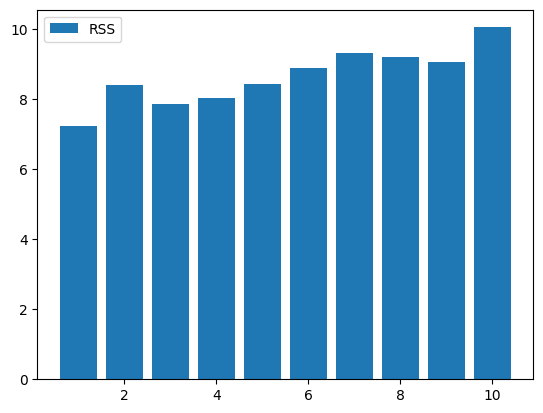

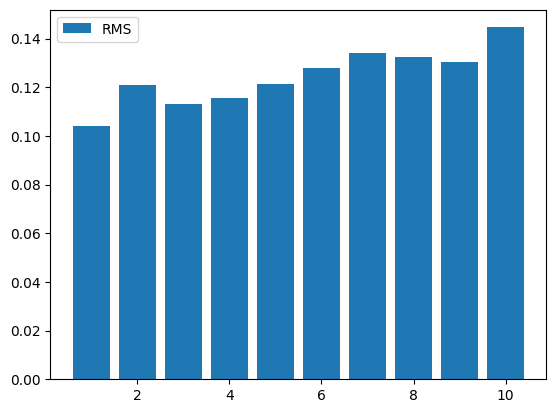

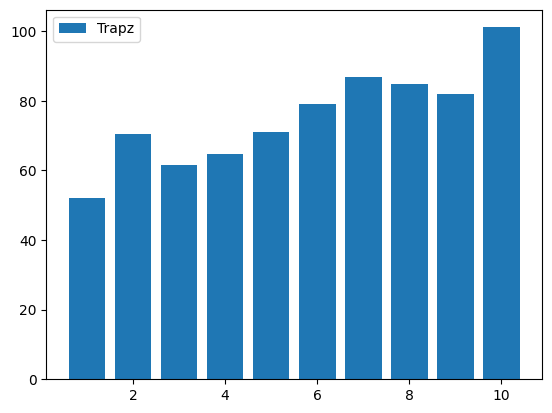

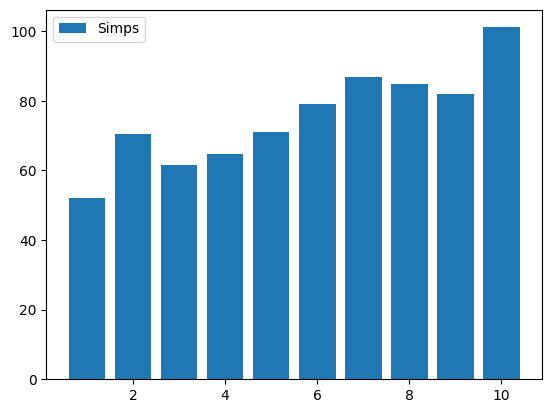

In [90]:
# plt.bar(np.arange(10) + 1, power[:, 0], label="Channel 1")
plt.bar(np.arange(10) + 1, power[:, 0], label="RSS")
plt.legend()
plt.show()

plt.bar(np.arange(10) + 1, power[:, 1], label="RMS")
plt.legend()
plt.show()

plt.bar(np.arange(10) + 1, power[:, 2], label="Trapz")
plt.legend()
plt.show()

plt.bar(np.arange(10) + 1, power[:, 3], label="Simps")
plt.legend()
plt.show()

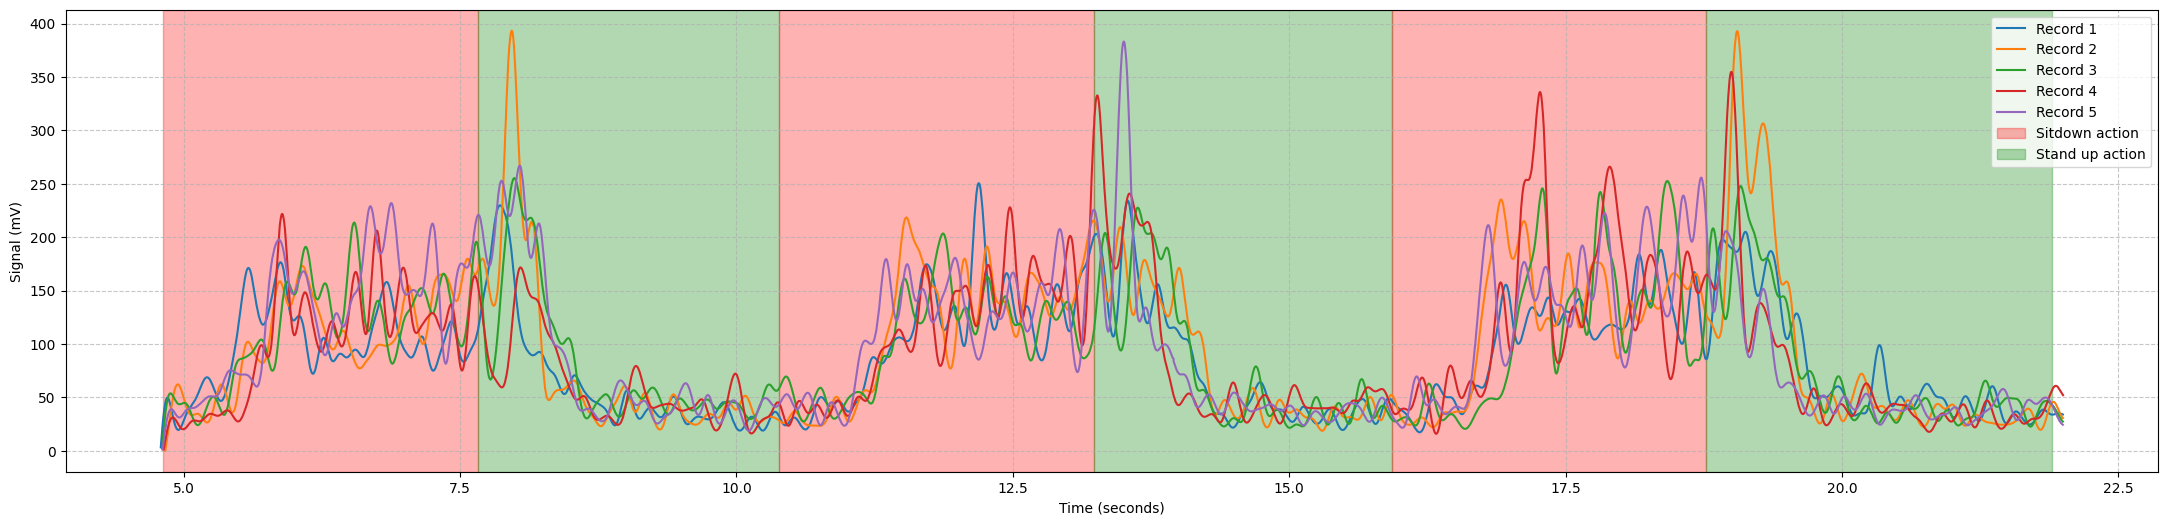

In [6]:
CHANNEL = 1
fig, axes = plt.subplots(1, 1, figsize=(27, 6))
for exp in range(1, 6):
    interval, emg, config = data_prepare(
        f"../data/sitting/exp_{exp}", low_pass=20, high_band=15, low_band=400
    )

    f, P = welch(emg[:, CHANNEL], fs=1000, window="hann", noverlap=0, nfft=int(256.0))
    area_freq = cumtrapz(P, f, initial=0)
    total_power = area_freq[-1]

    # fig.suptitle(f"Experiment {exp}; Power {total_power:.5f}")

    axes.plot(interval, emg[:, CHANNEL] * 1000, label=f"Record {exp}")

    axes.grid(True, linestyle="--", alpha=0.7)
    axes.set_xlabel("Time (seconds)")
    axes.set_ylabel("Signal (mV)")

    # f, t, Sxx = spectrogram(emg[:, CHANNEL], emg.shape[0] / (interval[-1] - interval[periods[0]]))
    # axes[1].pcolormesh(t + interval[periods[0]], f, Sxx, shading='gouraud')
    # axes[1].set_ylabel('Frequency [Hz]')
    # axes[1].set_xlabel('Time [sec]')
    # axes[1].set_ylim([0, 30])


c = ["r", "g"]
periods = []
for i in range(3):
    t0 = np.argwhere(interval >= config[f"close_{i}"])[0][0]
    tf = np.argwhere(interval >= config[f"open_{i}"])[0][0]
    periods.extend([t0, tf])
periods.append(np.argwhere(interval >= 21.9)[0][0])
for i in range(len(periods) - 1):
    if i in [0, 1]:
        axes.axvspan(
            interval[periods[i]],
            interval[periods[i + 1]],
            color=c[i % 2],
            alpha=0.3,
            label=f"{'Sitdown action' if i%2==0 else 'Stand up action'}",
        )
    else:
        axes.axvspan(
            interval[periods[i]], interval[periods[i + 1]], color=c[i % 2], alpha=0.3
        )
axes.legend()
plt.savefig("record_5_mid.png")

In [97]:
interval, emg, config = data_prepare(
    "../data/sitting/exp_4", low_pass=40, high_band=15, low_band=400
)
r = []
t = interval - interval[0]
s0, s1, step = 0, 0.25, 0.001
while s1 <= interval[-1]:
    d = np.argwhere((s0 <= t) & (t <= s1)).ravel()
    if d.shape[0] < 2:
        break
    fi, *_, li = d
    s0, s1 = s0 + step, s1 + step
    r.append([np.sqrt(np.mean(np.power(emg[fi:li, 1], 2))), np.mean(emg[fi:li, 1])])
r = np.array(r)

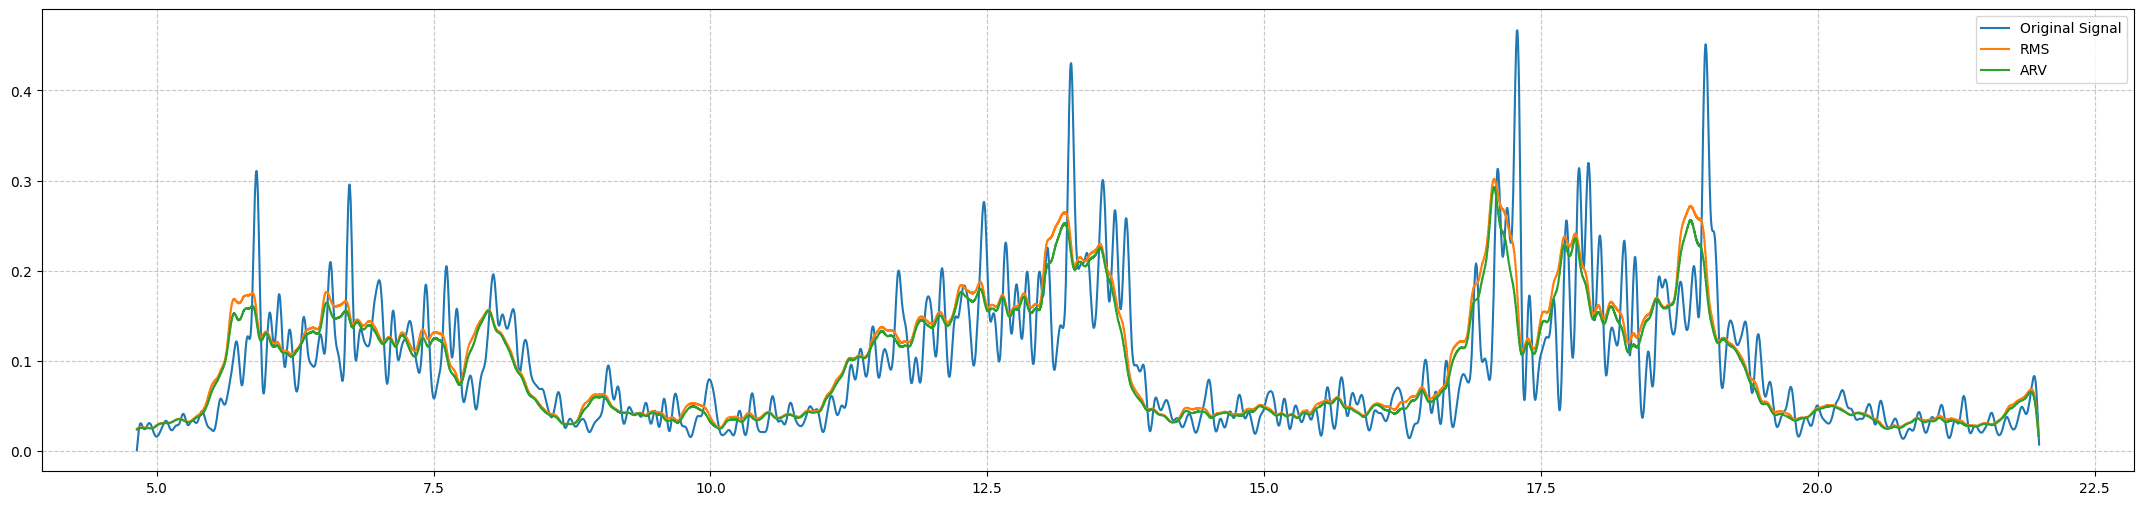

In [98]:
plt.figure(figsize=(27, 6))
plt.plot(interval, emg[:, 1], label="Original Signal")
plt.plot(
    np.arange(interval[0], interval[-1], step)[: r[:, 0].shape[0]], r[:, 0], label="RMS"
)
plt.plot(
    np.arange(interval[0], interval[-1], step)[: r[:, 0].shape[0]], r[:, 1], label="ARV"
)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

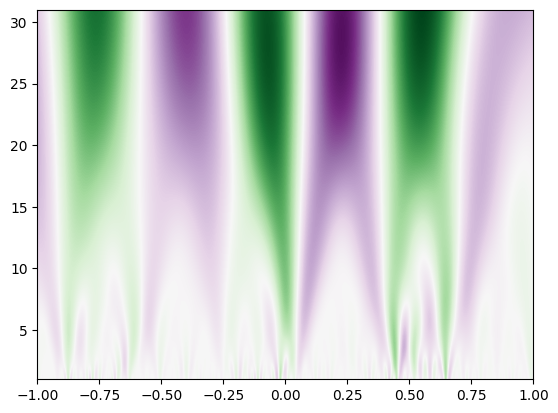

In [105]:
from scipy import signal

cwtmatr = signal.cwt(emg[:, 1], signal.ricker, np.arange(15, 400))
cwtmatr_yflip = np.flipud(cwtmatr)

plt.imshow(
    cwtmatr_yflip,
    extent=[-1, 1, 1, 31],
    cmap="PRGn",
    aspect="auto",
    vmax=abs(cwtmatr).max(),
    vmin=-abs(cwtmatr).max(),
)
plt.show()

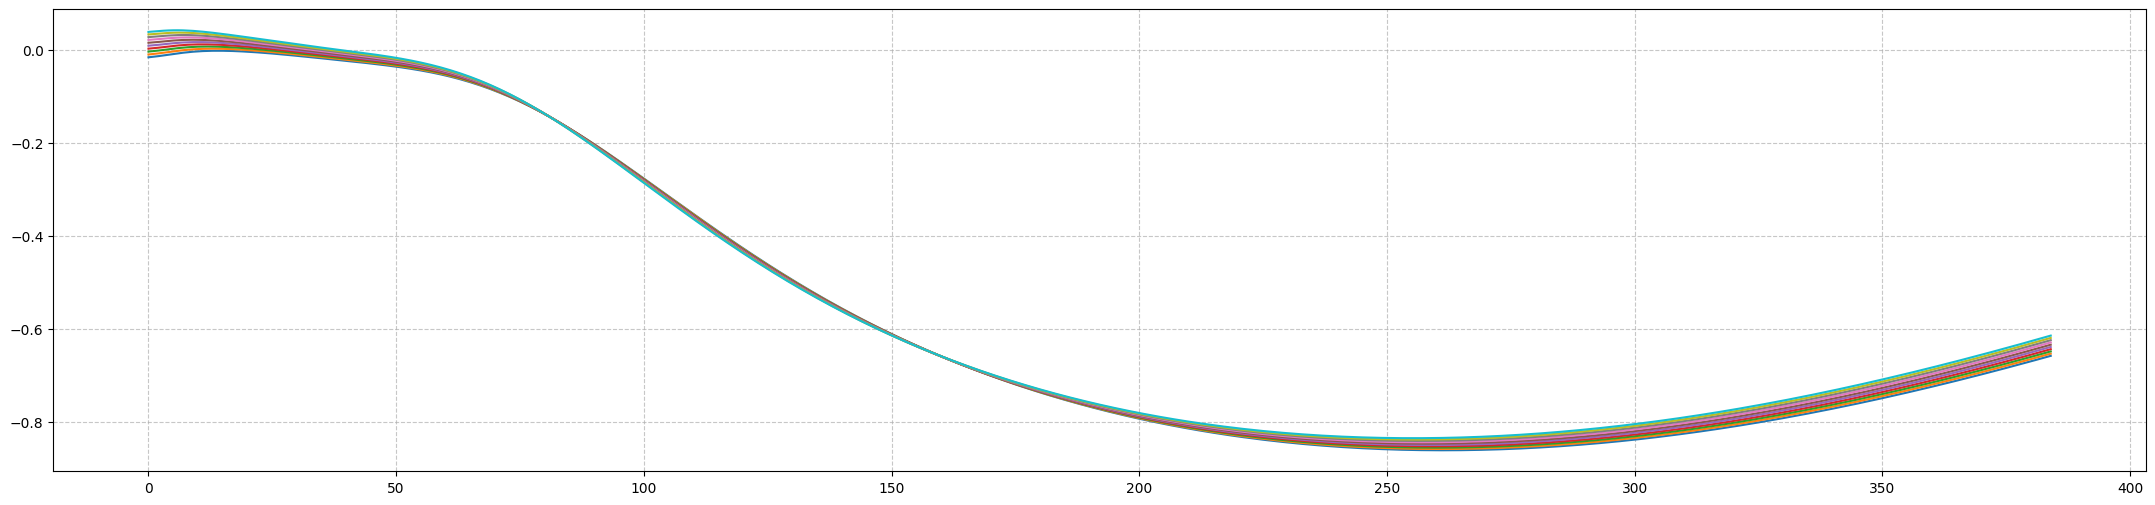

In [115]:
plt.figure(figsize=(27, 6))
plt.plot(cwtmatr[:, :10])
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()